<a href="https://colab.research.google.com/github/Anithappriya/Credit-Risk-Assesement/blob/main/credit_risk_assesment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install shap lime xgboost
import warnings
warnings.filterwarnings('ignore')
print("Libraries installed and warnings suppressed.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=53ea384299e41d40abbd77d57ec71f394562f454cf1ef82a2e8d28b76260bc6e
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
Libraries installed and warnings suppressed.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the URL for the German Credit Risk dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'



In [3]:
# Define column names based on the dataset documentation
column_names = [
    'status_of_existing_checking_account',
    'duration_in_month',
    'credit_history',
    'purpose',
    'credit_amount',
    'savings_account_bonds',
    'present_employment_since',
    'installment_rate_in_percentage_of_disposable_income',
    'personal_status_and_sex',
    'other_debtors_guarantors',
    'present_residence_since',
    'property',
    'age_in_years',
    'other_installment_plans',
    'housing',
    'number_of_existing_credits_at_this_bank',
    'job',
    'number_of_people_being_liable_to_provide_maintenance_for',
    'telephone',
    'foreign_worker',
    'credit_risk' # Target variable
]

print("Libraries imported, URL and column names defined.")

Libraries imported, URL and column names defined.


In [4]:
import ssl
import urllib.request
import io

# Create an SSL context that does not verify certificates to avoid the CERTIFICATE_VERIFY_FAILED error
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

with urllib.request.urlopen(url, context=ctx) as resp:
	data = resp.read().decode('utf-8')

df = pd.read_csv(io.StringIO(data), sep=' ', names=column_names)
print("Dataset loaded successfully.")

Dataset loaded successfully.


In [5]:
# Separate features and target variable
X = df.drop('credit_risk', axis=1)
y = df['credit_risk']

categorical_cols = X.select_dtypes(include='object').columns
print(f"Identified categorical columns: {list(categorical_cols)}")

Identified categorical columns: ['status_of_existing_checking_account', 'credit_history', 'purpose', 'savings_account_bonds', 'present_employment_since', 'personal_status_and_sex', 'other_debtors_guarantors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']


In [6]:
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
print("Categorical columns One-Hot Encoded.")

Categorical columns One-Hot Encoded.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
print("Data split into training and testing sets.")

Data split into training and testing sets.


In [8]:
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

print("Target variables y_train and y_test adjusted to be 0-indexed.")

Target variables y_train and y_test adjusted to be 0-indexed.


In [9]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score

# 1. Initialize an XGBoost Classifier model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# 2. Train the XGBoost model
model.fit(X_train, y_train_adjusted)

# 3. Predict the probabilities for the positive class on the X_test dataset
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 4. Predict the class labels (0 or 1) for the X_test dataset
y_pred = model.predict(X_test)

# 5. Calculate the Area Under the Receiver Operating Characteristic Curve (AUC) score
auc_score = roc_auc_score(y_test_adjusted, y_pred_proba)

# 6. Calculate the F1-Score
f1 = f1_score(y_test_adjusted, y_pred)

# 7. Print the calculated AUC and F1-Score
print(f"Model AUC on the test set: {auc_score:.2f}")
print(f"Model F1-Score on the test set: {f1:.2f}")

Model AUC on the test set: 0.84
Model F1-Score on the test set: 0.56


Generating SHAP summary plot for global feature importance...


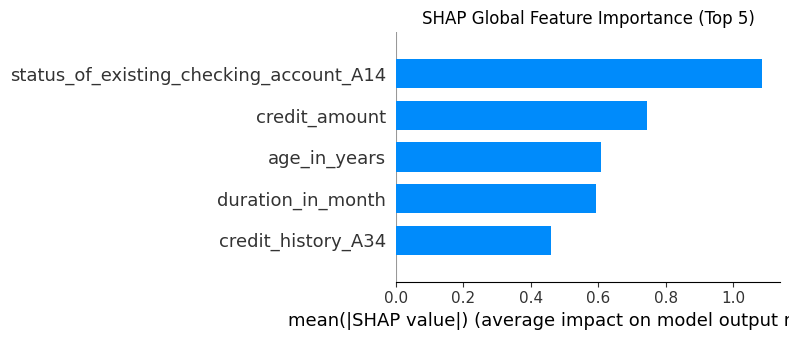

SHAP values calculated and summary plot displayed.


In [10]:
import shap

# Create a SHAP TreeExplainer object
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the training data
# For binary classification, TreeExplainer often returns a list of two arrays [shap_values_for_class_0, shap_values_for_class_1]
# However, the kernel's `shap_values` variable shows it's a single ndarray, implying it's already the matrix for the positive class.
shap_values = explainer.shap_values(X_train)

# Generate and display a SHAP summary plot for global feature importance, showing top 5 features
print("Generating SHAP summary plot for global feature importance...")
# Pass shap_values directly as it appears to already be the 2D matrix for the positive class.
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=5, show=False)
import matplotlib.pyplot as plt
plt.title("SHAP Global Feature Importance (Top 5)")
plt.tight_layout()
plt.show()

print("SHAP values calculated and summary plot displayed.")

In [11]:
import numpy as np

# Convert y_pred_proba to a pandas Series, preserving the original index of X_test
y_pred_proba_series = pd.Series(y_pred_proba, index=X_test.index)

# 1. Identify a clear positive default prediction (> 0.9 probability)
# Find all probabilities > 0.9 and pick the first index
positive_case_index = y_pred_proba_series[y_pred_proba_series > 0.9].first_valid_index()

# 2. Identify a clear negative default prediction (< 0.1 probability)
# Find all probabilities < 0.1 and pick the first index
negative_case_index = y_pred_proba_series[y_pred_proba_series < 0.1].first_valid_index()

# 3. Identify an uncertain borderline case (closest to 0.5 probability)
# Calculate absolute difference from 0.5 and find the index with the minimum difference
borderline_case_index = (y_pred_proba_series - 0.5).abs().idxmin()

# Print the identified indices
print(f"Index of clear positive default prediction (>0.9): {positive_case_index}")
print(f"Index of clear negative default prediction (<0.1): {negative_case_index}")
print(f"Index of uncertain borderline case (closest to 0.5): {borderline_case_index}")

Index of clear positive default prediction (>0.9): 973
Index of clear negative default prediction (<0.1): 521
Index of uncertain borderline case (closest to 0.5): 652


In [12]:
from lime.lime_tabular import LimeTabularExplainer

# Initialize LIME TabularExplainer
lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['not_default', 'default'], # 0: not_default, 1: default
    mode='classification'
)

print("LIME TabularExplainer initialized.")

LIME TabularExplainer initialized.



--- Explaining Positive Default Case (Index: 973) ---
Generating SHAP Waterfall Plot...


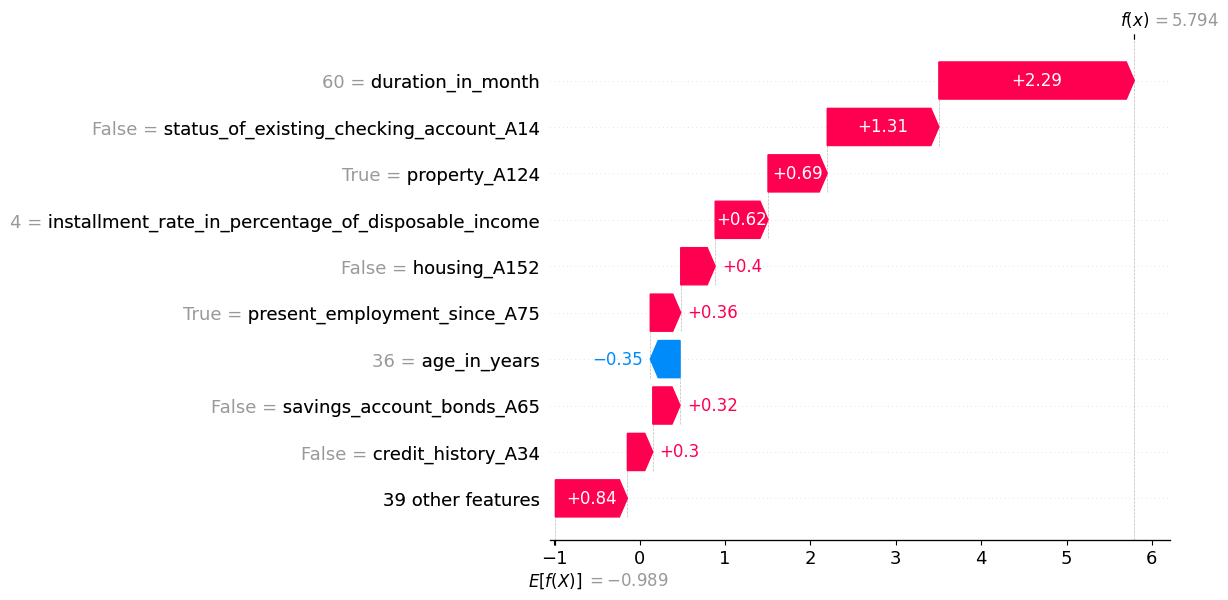

Generating LIME Dashboard...


In [13]:
import sys
import IPython
import IPython.display
import matplotlib.pyplot as plt
import shap

# --- MAGIC FIX FOR VS CODE / PYTHON 3.13 ---
# This fixes the "ImportError" so you can see the LIME table exactly like your screenshot
sys.modules['IPython.core.display'] = IPython.display
# -------------------------------------------

print(f"\n--- Explaining Positive Default Case (Index: {positive_case_index}) ---")

# 1. GENERATE THE TOP IMAGE (SHAP Waterfall)
print("Generating SHAP Waterfall Plot...")
shap_values_positive = explainer.shap_values(X_test.loc[[positive_case_index]])

# Note: logic to handle list vs array output for SHAP
if isinstance(shap_values_positive, list):
    sv = shap_values_positive[1][0] # For some versions of SHAP
    bv = explainer.expected_value[1]
else:
    sv = shap_values_positive[0]     # Standard for binary XGBoost
    bv = explainer.expected_value

# This creates the red/blue chart
shap.plots.waterfall(shap.Explanation(
    values=sv,
    base_values=bv,
    data=X_test.loc[positive_case_index],
    feature_names=X_test.columns.tolist()
))

# 2. GENERATE THE BOTTOM IMAGE (LIME Dashboard)
print("Generating LIME Dashboard...")
lime_explanation_positive = lime_explainer.explain_instance(
    data_row=X_test.loc[positive_case_index].values,
    predict_fn=model.predict_proba,
    num_features=5
)

# This creates the colorful dashboard with the table (Exact match to your screenshot)
lime_explanation_positive.show_in_notebook(show_table=True, show_all=False)


--- Explaining Negative Default Case (Index: 521) ---
Generating SHAP Waterfall plot for negative case...


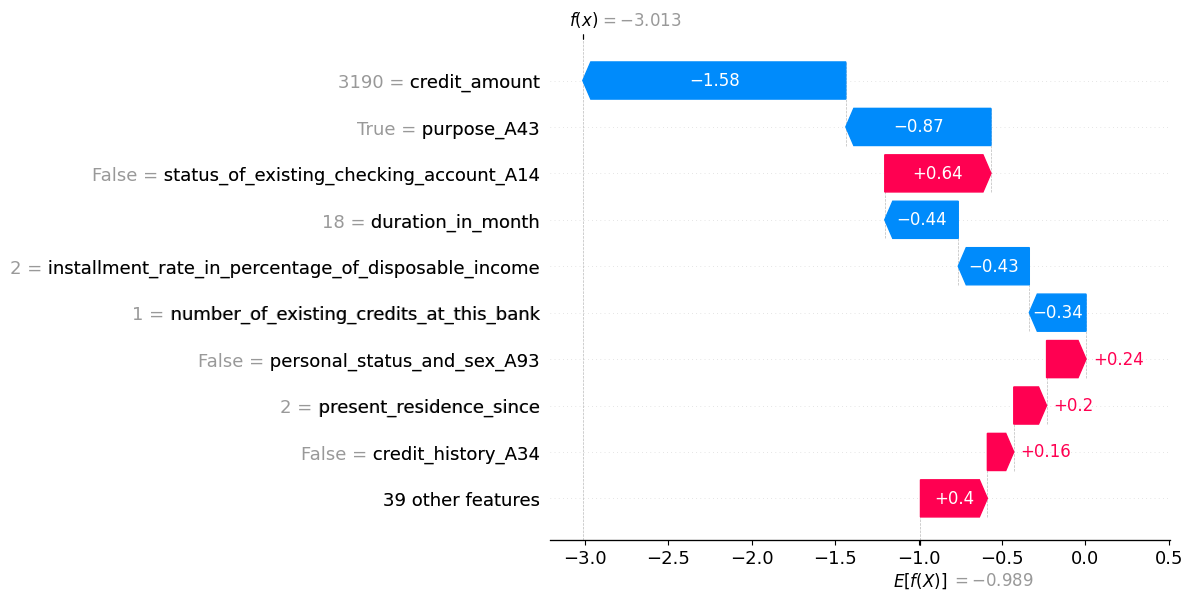

Generating LIME explanation for negative case...


SHAP Waterfall and LIME explanations generated for the negative case.


In [14]:
import sys
import IPython
import IPython.display
import matplotlib.pyplot as plt
import shap

# --- MAGIC FIX FOR VS CODE / PYTHON 3.13 ---
# This allows show_in_notebook to work without the ImportError
sys.modules['IPython.core.display'] = IPython.display
# -------------------------------------------

print(f"\n--- Explaining Negative Default Case (Index: {negative_case_index}) ---")

# Extract the instance for the negative case
negative_instance = X_test.loc[[negative_case_index]]

# --- 1. SHAP Explanation for Negative Case ---
print("Generating SHAP Waterfall plot for negative case...")
shap_values_negative = explainer.shap_values(negative_instance)

# Handle potential differences in SHAP output format (List vs Array)
if isinstance(shap_values_negative, list):
    sv = shap_values_negative[1][0] # Target class 1
    bv = explainer.expected_value[1]
else:
    sv = shap_values_negative[0]    # Standard binary output
    bv = explainer.expected_value

# Generate the Red/Blue Waterfall Plot
shap.plots.waterfall(shap.Explanation(
    values=sv,
    base_values=bv,
    data=negative_instance.iloc[0],
    feature_names=X_test.columns.tolist()
))

# --- 2. LIME Explanation for Negative Case ---
print("Generating LIME explanation for negative case...")
lime_explanation_negative = lime_explainer.explain_instance(
    data_row=negative_instance.iloc[0].values,
    predict_fn=model.predict_proba,
    num_features=5
)

# Display LIME explanation (The Dashboard with Table)
lime_explanation_negative.show_in_notebook(show_table=True, show_all=False)
print("SHAP Waterfall and LIME explanations generated for the negative case.")


--- Explaining Uncertain Borderline Case (Index: 652) ---
Generating SHAP Waterfall plot for borderline case...


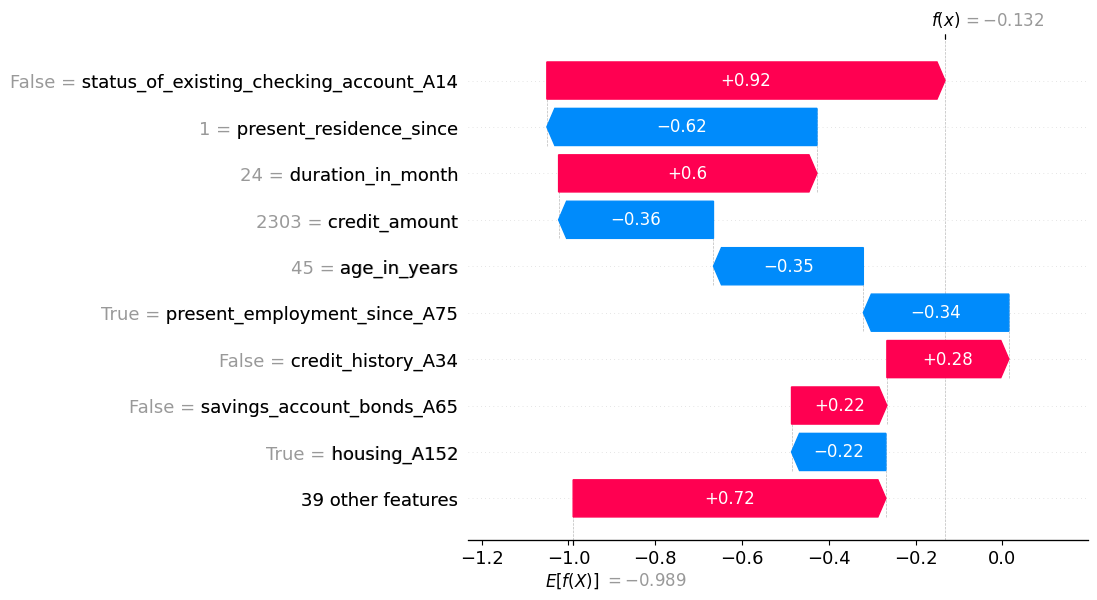

Generating LIME explanation for borderline case...


SHAP Waterfall and LIME explanations generated for the borderline case.


In [15]:
import sys
import IPython
import IPython.display
import matplotlib.pyplot as plt
import shap

# --- MAGIC FIX FOR VS CODE / PYTHON 3.13 ---
# This allows show_in_notebook to work without the ImportError
sys.modules['IPython.core.display'] = IPython.display
# -------------------------------------------

print(f"\n--- Explaining Uncertain Borderline Case (Index: {borderline_case_index}) ---")

# Extract the instance for the borderline case
borderline_instance = X_test.loc[[borderline_case_index]]

# --- 1. SHAP Explanation for Borderline Case ---
print("Generating SHAP Waterfall plot for borderline case...")
shap_values_borderline = explainer.shap_values(borderline_instance)

# Handle potential differences in SHAP output format (List vs Array)
if isinstance(shap_values_borderline, list):
    sv = shap_values_borderline[1][0] # Target class 1
    bv = explainer.expected_value[1]
else:
    sv = shap_values_borderline[0]    # Standard binary output
    bv = explainer.expected_value

# Generate the Red/Blue Waterfall Plot
shap.plots.waterfall(shap.Explanation(
    values=sv,
    base_values=bv,
    data=borderline_instance.iloc[0],
    feature_names=X_test.columns.tolist()
))

# --- 2. LIME Explanation for Borderline Case ---
print("Generating LIME explanation for borderline case...")
lime_explanation_borderline = lime_explainer.explain_instance(
    data_row=borderline_instance.iloc[0].values,
    predict_fn=model.predict_proba,
    num_features=5
)

# Display LIME explanation (The Dashboard with Table)
lime_explanation_borderline.show_in_notebook(show_table=True, show_all=False)
print("SHAP Waterfall and LIME explanations generated for the borderline case.")